#  Анализ данных о бронировании билетов на сервисе Яндекс.Афиша 
за период с 1 июня по 30 октября 2024 года

## Цели и задачи проекта

**Цель проекта:** проанализировать данные о бронировании билетов и выяснить факторы, значительно влияющие на спрос покупателей.

**Задачи:** 

- проанализировать, зависит ли спрос от фактора сезонности;
- изуить аудиторию в разрезе используемых устройств для бронирования билетов;
- выделить популярные регионы проведения мероприяятий и ключевых партнеров, приносящих наибольшую выручку.


## Описание данных

Данные представлены в двух датафреймах: `final_tickets_orders_df.csv` и `final_tickets_events_df.csv`. 

Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датафрейма: 
- `order_id` — уникальный идентификатор заказа
- `user_id` — уникальный идентификатор пользователя
- `reated_dt_msk` — дата создания заказа (московское время)
- `created_ts_msk` — дата и время создания заказа (московское время)
- `event_id` — идентификатор мероприятия из таблицы events
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'
- `age_limit` — возрастное ограничение мероприятия
- `currency_code` — валюта оплаты, например rub для российских рублей
- `evice_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных
- `revenue` — выручка от заказа
- `service_name` — название билетного оператора
- `tickets_count` — количество купленных билетов
- `total` — общая сумма заказа
- `days_since_prev` — количеством дней с предыдущей покупки для каждого пользователя

Второй датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит такие поля:
- `event_id` — уникальный идентификатор мероприятия
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных
- `event_type_description` — описание типа мероприятия
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее
- `organizers` — организаторы мероприятия
- `region_name` — название региона
- `city_name` — название города
- `venue_id` — уникальный идентификатор площадки
- `venue_name` — название площадки
- `venue_address` — адрес площадки

Также для обработки заказов оплаченных в казахстанских тенге представлен датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- `nominal` — номинал (100 тенге)
- `data` — дата
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## Содержимое проекта

1. [Загрузка данных и знакомсто с ними](#part1)
2. [Предварительная обработка данных](#part2)
3. [Исследовательский анализ данных](#part3)
    - 3.1 [Анализ распределения заказов по сегментам и их сезонные изменения](#part3)
    - 3.2 [Осенняя активность пользователей](#part4)
    - 3.3 [Популярные события и партнёры](#part5)
4. [Статистический анализ данных](#part6)
5. [Общий вывод и рекомендации](#part7)

## Обработка данных
<a name="part1"></a>
### Загрузка данных и знакомство с ними

In [1]:
# Загружаем необходимые библиотеки для работы с данными
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

import seaborn as sns

!pip install matplotlib-venn -q
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загружаем данные из файла в датафрейм
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')

final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')

final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
# Выводим первые 5 строк датафрейма 'final_tickets_orders_df'
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Выводим основную информацию о датафрейме 'final_tickets_orders_df'
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Датафрейм содержит 14 столбцов и 290849 строк. Данные представлены в следующих форматах int64, float64, object. Для полей, содержащих дату и время формат object является неподходящим. Необходимо изменить формат в столбцах `created_dt_msk`, `created_ts_msk` на datetime. Возможно снижение размерности количественных данных в столбцах: `order_id`,`event_id`, `age_limit`, `revenue`, `tickets_count`, `total`, `days_since_prev`.

In [5]:
# Выводим первые 5 строк датафрейма 'final_tickets_events_df'
final_tickets_events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
# Выводим основную информацию о датафрейме 'final_tickets_events_df'
final_tickets_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Датафрейм содержит 11 столбцов и 22427 строк. Данные представлены в следующих форматах int64, object. Формат данных является корректным для всех полей датафрейма. Возможно снижение размерности количественных данных в столбцах: `event_id`, `city_id`, `venue_id`.

In [7]:
# Выводим первые 5 строк датафрейма 'final_tickets_tenge_df'
final_tickets_tenge_df.head() 

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
# Выводим основную информацию о датафрейме 'final_tickets_tenge_df'
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датафрейм содержит 4 столбца и 357 строк. Данные представлены в следующих форматах int64, float64, object. Формат данных для столбца `data` является некорректным, необходимо поменять формат на datetime. Возможно снижение размерности количественных данных в столбцах: `nominal`, `curs`.

При первичном анализе данных выявлено, что набор данных полон и содержит необходимую информацию для дальнейшего исследования. Однако для проведения глубокого анализа и обеспечения точности результатов требуется дополнительная предварительная обработка данных.

Основные этапы предварительной обработки:

- Проверка данных на наличие пропусков: необходимо идентифицировать и обработать пропущенные значения, чтобы избежать искажений при анализе.

- Проверка данных на явные и неявные дубликаты: дубликаты могут привести к искажению результатов анализа. Необходимо выявить и удалить явные дубликаты, а также рассмотреть возможность наличия строк с частично повторяющейся информацией.

- Анализ категорийных данных: проанализировать категории, встречающиеся в данных, возможные смысловые повторы категорий или наличие категорий, обозначающих отсутствие данных.

- Анализ распределения количественных значений и наличия выбросов: необходимо изучить распределение количественных переменных, определить наличие выбросов и рассмотреть методы их обработки. Выбросы могут существенно влиять на результаты анализа и модели машинного обучения.

- Преобразование форматов данных в полях с датой и временем: форматы данных в полях с датой и временем необходимо преобразовать в стандартизированный формат datetime. Это позволит эффективно использовать временные метки для различных аналитических операций, таких как сортировка, фильтрация и агрегация данных по временным периодам.

- Уменьшение размерности численных данных: численные данные можно преобразовать для уменьшения размерности, что приведёт к сокращению объёма занимаемой памяти и ускорению обработки данных.

<a name="part2"></a>
### Предобработка данных и подготовка их к исследованию

In [9]:
# Обединение данных в один датафрейм
final_tickets_df_rub_and_kzt = final_tickets_orders_df.merge(final_tickets_events_df, on='event_id', how='inner')
final_tickets_df = final_tickets_df_rub_and_kzt.merge(final_tickets_tenge_df, left_on='created_dt_msk', right_on='data')

In [10]:
# Проверяем данные в объединенном датафрейме
final_tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name          

In [11]:
row_amt = final_tickets_df.shape[0]
print(f'Количество строк в изначальном датафрейме:{row_amt}')

Количество строк в изначальном датафрейме:290611


In [12]:
# Проверяем наличие пропусков в датафрейме 'final_tickets_orders_df'
final_tickets_df.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
data                          0
nominal                       0
curs                          0
cdx                           0
dtype: int64

В датафрейме `final_tickets_df` пропуски есть только в столбце `days_since_prev`, который отображает колтчество дней с предыдущего заказа для каждого покупателя. Наличие пропусков в данном столбце оправдано, т.к. есть покупки, которые являются первыми для покупателя за выбранный период.

In [13]:
# Проверяем значения категориальных данных в столбце 'currency_code'
final_tickets_df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [14]:
# Проверяем значения категориальных данных в столбце 'device_type_canonical'
final_tickets_df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [15]:
# Проверяем значения категориальных данных в столбце 'service_name'
final_tickets_df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'Облачко', 'Быстробилет',
       'Билеты без проблем', 'Весь в билетах', 'Билеты в руки',
       'Прачечная', 'Лови билет!', 'Лучшие билеты', 'Дом культуры',
       'За билетом!', 'Яблоко', 'Show_ticket', 'Тебе билет!', 'Мир касс',
       'Выступления.ру', 'Восьмёрка', 'Городской дом культуры',
       'Росбилет', 'Вперёд!', 'Crazy ticket!', 'Телебилет',
       'Радио ticket', 'Кино билет', 'Зе Бест!', 'КарандашРУ',
       'Шоу начинается!', 'Лимоны', 'Билет по телефону', 'Тех билет',
       'Дырокол', 'Быстрый кассир', 'Реестр', 'Цвет и билет',
       'Билеты в интернете'], dtype=object)

In [16]:
# Проверяем значения категориальных данных в столбце 'event_type_description'
final_tickets_df['event_type_description'].unique()

array(['спектакль', 'событие', 'шоу', 'концерт', 'ёлка', 'цирковое шоу',
       'выставка', 'мюзикл', 'фестиваль', 'балет',
       'спортивное мероприятие', 'спорт', 'опера',
       'музыкальный спектакль', 'экскурсия', 'кукольный спектакль',
       'подарок', 'снегурочка', 'оперетта', 'рок-мюзикл'], dtype=object)

In [17]:
# Проверяем значения категориальных данных в столбце 'event_type_main'
final_tickets_df['event_type_main'].unique()

array(['театр', 'выставки', 'стендап', 'концерты', 'ёлки', 'другое',
       'спорт'], dtype=object)

In [18]:
# Проверяем значения категориальных данных в столбце 'region_name'
final_tickets_df['region_name'].unique()

array(['Каменевский регион', 'Североярская область', 'Ветренский регион',
       'Боровлянский край', 'Озернинский край', 'Ягодиновская область',
       'Горицветская область', 'Широковская область',
       'Речиновская область', 'Каменноярский край',
       'Малиновоярский округ', 'Ручейковский край', 'Медовская область',
       'Тепляковская область', 'Малиновая область', 'Яблоневская область',
       'Глиногорская область', 'Зоринский регион', 'Серебринская область',
       'Травиницкий округ', 'Шанырский регион', 'Заречная область',
       'Лесодальний край', 'Травяная область', 'Каменополянский округ',
       'Речицкая область', 'Светополянский округ', 'Лугоградская область',
       'Озернопольская область', 'Солнечнореченская область',
       'Голубевский округ', 'Дальнеземская область',
       'Крутоводская область', 'Дальнезорский край', 'Поленовский край',
       'Чистогорская область', 'Солнечноземская область',
       'Лесоярская область', 'Синегорский регион', 'Зеленоградск

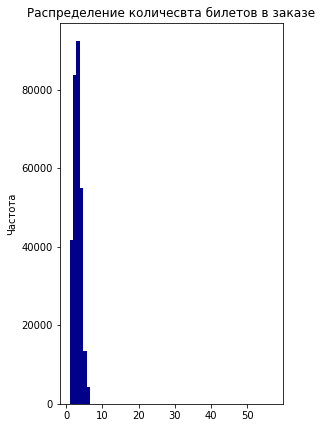

In [19]:
# Строим диаграмму распределения значений столбца 'tickets_count'
final_tickets_df['tickets_count'].plot(
    kind='hist',
    bins=60,
    color='darkblue',
    figsize=(4,7)
)

# Задаем название графика и подписи осей
plt.title('Распределение количесвта билетов в заказе')
plt.ylabel('Частота')

# Выводим график на экран
plt.show()

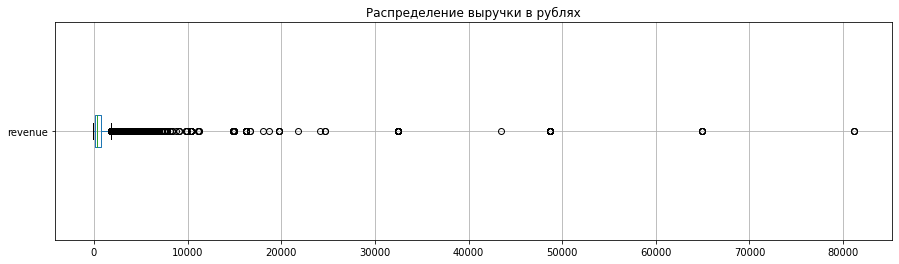

In [20]:
# Строим график boxplot для выруручки в рублях
# Отбираем заказы, оплаченные в рублях
orders_df_rub = final_tickets_df[final_tickets_df['currency_code'] == 'rub']

# Задаем размер графика
plt.figure(figsize=(15,4))

# Строим график 
orders_df_rub.boxplot('revenue', vert=False)

# Задаем название графику
plt.title('Распределение выручки в рублях')

# Выводим график на экран
plt.show()

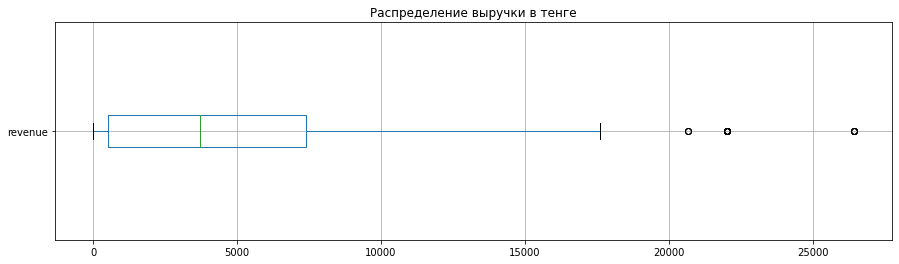

In [21]:
# Строим график boxplot для выруручки в тенге
# Отбираем заказы, оплаченные в тенге
orders_df_kzt = final_tickets_df[final_tickets_df['currency_code'] == 'kzt']

# Задаем размер графика
plt.figure(figsize=(15,4))

# Строим график
orders_df_kzt.boxplot('revenue', vert=False)

# Задаем название графику
plt.title('Распределение выручки в тенге')

# Выводим график на экран
plt.show()

При анализе данных о выручке были обнаружены выбросы в значениях, выраженных как в рублях, так и в тенге. Выбросы могут существенно исказить результаты анализа, поэтому для улучшения качества данных и повышения точности анализа необходимо провести дополнительную обработку этих значений. Необходимо выбрать значения выручки, которые не превышают 99-й перцентиль.

In [22]:
# Находим значение равное 99-му перцентилю для выручки в рублях
percentile_99_ru = np.percentile(orders_df_rub['revenue'], 99)

In [23]:
# Отбираем заказы в рублях, в которых выручка мненьше значения, равного 99-му перцентилю
orders_df_rub_99 = orders_df_rub[orders_df_rub['revenue'] <= percentile_99_ru]

In [24]:
# Находим значение равное 99-му перцентилю для выручки в тенге
percentile_99_kz = np.percentile(orders_df_kzt['revenue'], 99)

In [25]:
# Отбираем заказы в тенге, в которых выручка мненьше значения, равного 99-му перцентилю
orders_df_kzt_99 = orders_df_kzt[orders_df_kzt['revenue'] <= percentile_99_kz]

In [26]:
# Фильтруем основной датасет 'final_tickets_df', отбирая значения выручки, которые мненьше значения, равного 99-му перцентилю
final_tickets_df = final_tickets_df[
    (final_tickets_df['order_id'].isin(orders_df_rub_99['order_id'])) |
    (final_tickets_df['order_id'].isin(orders_df_kzt_99['order_id']))
]

In [27]:
# Проверяем полученный результат после удаления строк
final_tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287782 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                287782 non-null  int64  
 1   user_id                 287782 non-null  object 
 2   created_dt_msk          287782 non-null  object 
 3   created_ts_msk          287782 non-null  object 
 4   event_id                287782 non-null  int64  
 5   cinema_circuit          287782 non-null  object 
 6   age_limit               287782 non-null  int64  
 7   currency_code           287782 non-null  object 
 8   device_type_canonical   287782 non-null  object 
 9   revenue                 287782 non-null  float64
 10  service_name            287782 non-null  object 
 11  tickets_count           287782 non-null  int64  
 12  total                   287782 non-null  float64
 13  days_since_prev         266070 non-null  float64
 14  event_name          

In [28]:
# Проверяем наличие явных дубликатов
final_tickets_df.duplicated().sum()

0

In [29]:
# Проверяем наличие дубликатов по столбцам, отображающим основную информацию о заказе 
final_tickets_df[['user_id', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'venue_name',
       'venue_address']].duplicated().sum()

39

Обнаружено 39 дублирующихся строк по столбцам, отображающим основную информацию о заказе (идентификационный номер пользователя,  дата и время заказа, устройство, с которого был сделан заказ, валюта оплаты, доход с заказа, название билетного оператора, количество билетов в заказе название мероприятия, организатор, название площадки и ее адрес, название региона).
Данные дубликаты составляют незначительный процент от общего количества заказов и подлежат удалению.

In [30]:
# Удаляем из основного датасета 'final_tickets_df' обнаруженные дублирующиеся строки
final_tickets_df = final_tickets_df.drop_duplicates(subset=['user_id', 'created_ts_msk', 'event_id','cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical','revenue', 'service_name', 'tickets_count', 'total','event_name', 'event_type_description', 'event_type_main', 'organizers','region_name', 'city_name', 'venue_name','venue_address'])

In [31]:
# Проверяем полученный результат после удаления строк
final_tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287743 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                287743 non-null  int64  
 1   user_id                 287743 non-null  object 
 2   created_dt_msk          287743 non-null  object 
 3   created_ts_msk          287743 non-null  object 
 4   event_id                287743 non-null  int64  
 5   cinema_circuit          287743 non-null  object 
 6   age_limit               287743 non-null  int64  
 7   currency_code           287743 non-null  object 
 8   device_type_canonical   287743 non-null  object 
 9   revenue                 287743 non-null  float64
 10  service_name            287743 non-null  object 
 11  tickets_count           287743 non-null  int64  
 12  total                   287743 non-null  float64
 13  days_since_prev         266031 non-null  float64
 14  event_name          

In [32]:
# Преобразуем тип данных в формат 'datetime' в столбцах, содержащих дату и время
for column in ['created_dt_msk','created_ts_msk','data']:
    final_tickets_df[column] = pd.to_datetime(final_tickets_df[column])

In [33]:
# Уменьшаем размерность целочисленных данных
for column in ['order_id','event_id','age_limit','tickets_count','days_since_prev','city_id','venue_id','nominal']:
    final_tickets_df[column] = pd.to_numeric(final_tickets_df[column], downcast='integer')

In [34]:
# Уменьшаем размерность вещественных данных 
for column in ['revenue','total','curs']:
    final_tickets_df[column] = pd.to_numeric(final_tickets_df[column], downcast='float')

In [35]:
# Проверяем типы данных в столбцах после внесенных изменений 
final_tickets_df.dtypes

order_id                           int32
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int32
cinema_circuit                    object
age_limit                           int8
currency_code                     object
device_type_canonical             object
revenue                          float32
service_name                      object
tickets_count                       int8
total                            float32
days_since_prev                  float64
event_name                        object
event_type_description            object
event_type_main                   object
organizers                        object
region_name                       object
city_name                         object
city_id                            int32
venue_id                           int16
venue_name                        object
venue_address                     object
data            

In [36]:
# Создаем новый столбец с выручкой в рублях 
# Переводим выручку, указанную в тенге в рубли по курсу на день оформдения заказа
final_tickets_df.loc[final_tickets_df['currency_code'] == 'kzt', 'revenue_rub'] = final_tickets_df['revenue'] * (final_tickets_df['curs'] / final_tickets_df['nominal'])
final_tickets_df.loc[final_tickets_df['currency_code'] == 'rub', 'revenue_rub'] = final_tickets_df['revenue']

In [37]:
# Проверяем полученный результат
final_tickets_df[final_tickets_df['currency_code'] == 'kzt'].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub
197,7315193,3ee7dc2e115847f,2024-08-20,2024-08-20 17:11:15,533803,нет,16,kzt,mobile,1849.410034,...,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",2024-08-20,100,18.697201,kzt,345.787903
198,5512843,6c343a9a8a5fb89,2024-08-20,2024-08-20 14:51:57,533803,нет,16,kzt,mobile,5548.240234,...,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",2024-08-20,100,18.697201,kzt,1037.365601
199,5512785,6c343a9a8a5fb89,2024-08-20,2024-08-20 15:00:41,533803,нет,16,kzt,mobile,1849.410034,...,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",2024-08-20,100,18.697201,kzt,345.787903
200,5512814,6c343a9a8a5fb89,2024-08-20,2024-08-20 14:55:30,533803,нет,16,kzt,mobile,5548.240234,...,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",2024-08-20,100,18.697201,kzt,1037.365601
201,7134697,8a3dacb24c96aa2,2024-08-20,2024-08-20 07:56:42,533803,нет,16,kzt,mobile,1849.410034,...,Широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",2024-08-20,100,18.697201,kzt,345.787903


In [38]:
# Создаем новый столбец с выручкой в рублях за один билет
final_tickets_df['one_ticket_revenue_rub'] = final_tickets_df['revenue_rub'] / final_tickets_df['tickets_count']

In [39]:
# Создаем новый столбец с месяцем оформления заказа
final_tickets_df['month'] = final_tickets_df['created_dt_msk'].dt.month

In [40]:
# Создаем новый столбец с указанием сезона оформления заказа
final_tickets_df.loc[(final_tickets_df['month'] >= 6) & (final_tickets_df['month'] <= 8), 'season'] = 'summer'
final_tickets_df.loc[(final_tickets_df['month'] >= 9) & (final_tickets_df['month'] <= 11), 'season'] = 'autumn'

In [41]:
# Проверяем полученый результат
final_tickets_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt,1521.939941,380.484985,8,summer
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.729996,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.697201,kzt,144.729996,144.729996,8,summer
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.269989,...,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.697201,kzt,318.269989,106.089996,8,summer
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.609985,...,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt,339.609985,339.609985,8,summer
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.609985,...,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt,339.609985,339.609985,8,summer


In [42]:
final_tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287743 entries, 0 to 290610
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287743 non-null  int32         
 1   user_id                 287743 non-null  object        
 2   created_dt_msk          287743 non-null  datetime64[ns]
 3   created_ts_msk          287743 non-null  datetime64[ns]
 4   event_id                287743 non-null  int32         
 5   cinema_circuit          287743 non-null  object        
 6   age_limit               287743 non-null  int8          
 7   currency_code           287743 non-null  object        
 8   device_type_canonical   287743 non-null  object        
 9   revenue                 287743 non-null  float32       
 10  service_name            287743 non-null  object        
 11  tickets_count           287743 non-null  int8          
 12  total                   287743

In [43]:
print(f'Доля удаленных строк из датафрейма: {round((row_amt - final_tickets_df.shape[0]) / row_amt * 100, 2)}%')

Доля удаленных строк из датафрейма: 0.99%


**Результаты предварительной обработки данных:**
- Перед обработкой мы объединили датафреймы, содержащие информацию о заказах, событиях и курсе тенге на момент оформления заказа. Это позволило создать более полный и информативный набор данных для дальнейшего анализа.
- В результате обработки из изначальных 290611 строк осталось 287743, что свидетельствует об удалении незначительного процента данных (0,99 %). Это указывает на то, что основная часть данных была сохранена и может быть использована для анализа.
- Были удалены строки, дублирующиеся по основным столбцам, описывающим информацию о заказах. Также были исключены выбросы по значению выручки, которые превышали 99-й перцентиль. Это позволило повысить точность и надёжность последующих аналитических выводов.
- Преобразованы типпы данных: данные содержащие дату и время приведены к формату `datetime`, а для численных данных была снижена размерность. Это улучшило структуру данных и оптимизировало их для анализа.
- Созданы новые столбцы для дальнейшего анализа данных: 
    - `revenue_rub` - выручка в рублях
    - `one_ticket_revenue_rub` - выручка в рублях за один билет
    - `month` - месяц оформления заказа
    - `season` - сезон оформления заказа
    
Эти дополнительные столбцы позволят провести более детальный и глубокий анализ данных, выявить закономерности и тенденции, а также сделать обоснованные выводы на основе полученных результатов.

<a name="part3"></a>
### Исследовательский анализ данных 
#### Анализ распределения заказов по сегментам и их сезонные изменения

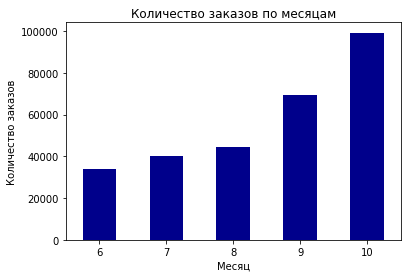

In [44]:
# Группируем данные по месяцу заказа и подсчитываем количесвто заказов
orders_per_month = final_tickets_df.groupby('month')['order_id'].count()

# Строим столбчатую диаграмму для количесвта заказов по месяцам 
orders_per_month.plot(
    kind='bar',
    rot=0,
    color='darkblue',
    grid=False,
    title='Количество заказов по месяцам',
    xlabel='Месяц',
    ylabel='Количество заказов'
)

# Выводим график на экран
plt.show()

Наблюдается значительный рост количества заказов к концу изучаемого периода, осебенно в осенние месяцы.

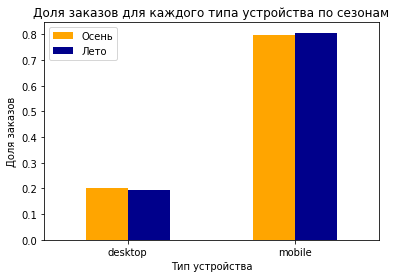

In [45]:
# Проверяем равномерность распределения количества заказов по утсройствам летом и осенью
# Подсчитываем количество заказов по каждому устройству в каждый сезон
grouped_orders = final_tickets_df.groupby('device_type_canonical')['season'].value_counts().unstack()

# Нормализуем данные, чтобы получить доли
grouped_orders_proportions = grouped_orders.apply(lambda x: x / x.sum(), axis=0)

# Строим столбчатую диаграмму для доли заказов в оба сезона
grouped_orders_proportions.plot(
    kind='bar',
    rot=0,
    color=['orange','darkblue']
)

# Задаем название графика и подписи осей
plt.title('Доля заказов для каждого типа устройства по сезонам')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')
plt.legend(['Осень', 'Лето'])

# Выводим график на экран
plt.show()

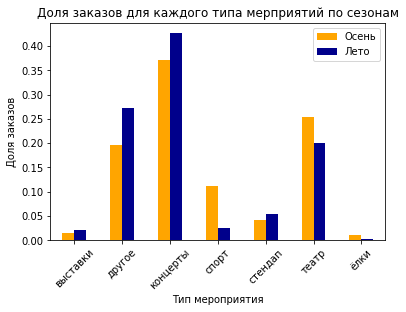

In [46]:
# Проверяем равномерность распределения количества заказов по типу мероприятия летом и осенью
# Подсчитываем количество заказов по каждому типу мероприятия в каждый сезон
grouped_season_orders = final_tickets_df.groupby('event_type_main')['season'].value_counts().unstack()

# Нормализуем данные, чтобы получить доли
grouped_season_orders_proportions = grouped_season_orders.apply(lambda x: x / x.sum(), axis=0)

grouped_season_orders_proportions.plot(
    kind='bar',
    rot=45,
    color=['orange','darkblue']
)

# Задаем название графика и подписи осей
plt.title('Доля заказов для каждого типа мерприятий по сезонам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля заказов')
plt.legend(['Осень', 'Лето'])

# Выводим график на экран
plt.show()

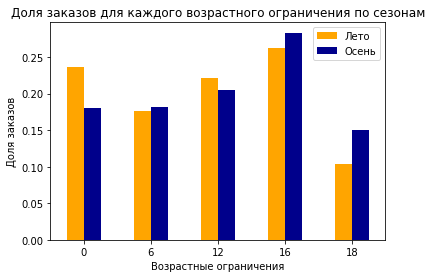

In [47]:
# Проверяем равномерность распределения количества заказов по типу мероприятия летом и осенью
# Подсчитываем количество заказов по каждому типу мероприятия в каждый сезон
grouped_age_orders = final_tickets_df.groupby('age_limit')['season'].value_counts().unstack()

# Нормализуем данные, чтобы получить доли
grouped_age_orders_proportions = grouped_age_orders.apply(lambda x: x / x.sum(), axis=0)

grouped_age_orders_proportions.plot(
    kind='bar',
    rot=0,
    color=['orange','darkblue']
)

# Задаем название графика и подписи осей
plt.title('Доля заказов для каждого возрастного ограничения по сезонам')
plt.xlabel('Возрастные ограничения')
plt.ylabel('Доля заказов')
plt.legend(['Лето', 'Осень'])

# Выводим график на экран
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b>Удачные корректировки, стало нагляднее

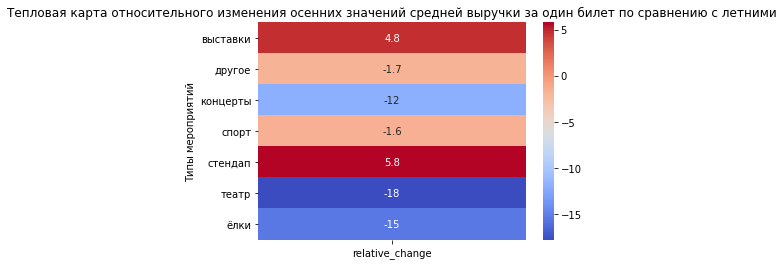

In [48]:
# Сравниваем выручку с продажи одного билета в зависимости от типа мероприятия летом и осенью
# Подсчитываем среднюю выручку с продажи одного билета по типу мероприятия в каждый сезон
avg_one_ticket_revenue_summer = final_tickets_df[final_tickets_df['season'] == 'summer'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()

avg_one_ticket_revenue_autumn = final_tickets_df[final_tickets_df['season'] == 'autumn'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()

# Объединяем средние значения в один DataFrame для удобства сравнения
combined_revenue = pd.DataFrame({
    'summer': avg_one_ticket_revenue_summer,
    'autumn': avg_one_ticket_revenue_autumn
})

# Рассчитываем относительное изменение
combined_revenue['relative_change'] = (combined_revenue['autumn'] - combined_revenue['summer']) / combined_revenue['summer'] * 100

# Выделяем столбец со значениями относительного изменения средней выручки за один билет
column_data = combined_revenue[['relative_change']]

# Строим тепловую карту
sns.heatmap(column_data, annot=True, cmap='coolwarm')

# Задаем название графика и подписи осей
plt.title('Тепловая карта относительного изменения осенних значений средней выручки за один билет по сравнению с летними')
plt.ylabel('Типы мероприятий')

# Выводим график на экран
plt.show()

Анализ данных заказов за период с июня по октябрь 2024 года показывает устойчивый рост общего количества заказов, при этом осенние месяцы характеризуются особенно значительным увеличением активности покупателей.

Распределение заказов по типу устройства для покупки билетов остаётся одинаковым как в летний, так и в осенний периоды — доля заказов через разные устройства примерно равна и не меняется со сменой сезона. Это указывает на постоянные предпочтения аудитории в выборе платформы для покупки.

Заметны сезонные изменения в предпочтениях по типу мероприятий: летом больше заказов на концерты, выставки, стендап и прочие развлечения, тогда как осенью растёт спрос на спортивные события, театральные постановки и новогодние ёлки. Эти сдвиги логичны — осенью стартуют театральный сезон и спортивные чемпионаты, а ёлки традиционно актуальны к зимним праздникам.

По возрастным ограничениям выявлена следующая тенденция: летом больше заказов на мероприятия с возрастным ограничением «6+», «16+», «18+», что говорит о популярности мероприятий для подростков и взрослых. Осенью же повышается доля мероприятий с ограничениями «0+» и «12+», что свидетельствует о росте востребованности детских и семейных событий.

Что касается выручки с одного билета, летом она выше для концертов, театра, спорта, ёлок и категории «другое», а осенью — для выставок и стендапа. Это может отражать различия в ценовой политике и популярности конкретных мероприятий в разные сезоны.

В целом, эти данные позволяют сделать вывод, что сезонность существенным образом влияет на структуру и спрос по типу мероприятий и возрастным категориям, при этом выбор устройства для заказа остаётся устойчивым.

<a name="part4"></a>
#### Осенняя активность пользователей

In [49]:
# Создаем сводную таблицу
# Отфильтровываем данные за осенний период
autumn_orders = final_tickets_df[final_tickets_df['season'] == 'autumn']

# Находим общее количество заказов за каждый день
autumn_activity = autumn_orders.groupby('created_dt_msk')['order_id'].count().reset_index(name='total_orders')

# Находим количество активных пользователей за каждый день
autumn_dau = autumn_orders.groupby('created_dt_msk')['user_id'].nunique().reset_index(name='DAU')

# Объединяем столбцы с общим количеством заказов и активных пользователей за каждый день
autumn_us_activ = autumn_activity.merge(autumn_dau, on='created_dt_msk', how='inner')

# Находим среднее количество заказов на одного пользователя за каждый день
autumn_avg_one_ticket_revenue = autumn_orders.groupby('created_dt_msk')['one_ticket_revenue_rub'].mean().reset_index(name='avg_one_ticket_revenue')

# Находим среднюю стоимость одного билета за каждый день
autumn_us_activ['orders_per_user'] = autumn_us_activ['total_orders'] / autumn_us_activ['DAU']

# Присоединяем среднюю стоимость одного билета за каждый день к сводной таблице
autumn_users_activity = autumn_us_activ.merge(autumn_avg_one_ticket_revenue, on='created_dt_msk', how='inner')

# Выделяем день недели для анализа недельной цикличности
autumn_users_activity['day_of_week_name'] = autumn_users_activity['created_dt_msk'].dt.day_of_week

# Назначаем столбец с датой индексом
autumn_users_activity = autumn_users_activity.set_index('created_dt_msk')

# Выводим полученную таблицу на экран
display(autumn_users_activity)

,total_orders,DAU,orders_per_user,avg_one_ticket_revenue,day_of_week_name
created_dt_msk,,,,,
2024-09-01,1327,564,2.352837,200.168708,6
2024-09-02,1380,574,2.404181,189.464640,0
2024-09-03,5113,778,6.571979,80.350151,1
2024-09-04,1773,686,2.584548,178.048069,2
2024-09-05,1944,739,2.630582,189.510155,3
...,...,...,...,...,...
2024-10-27,2849,1034,2.755319,186.968329,6
2024-10-28,2838,985,2.881218,170.654940,0
2024-10-29,2835,998,2.840681,177.366072,1


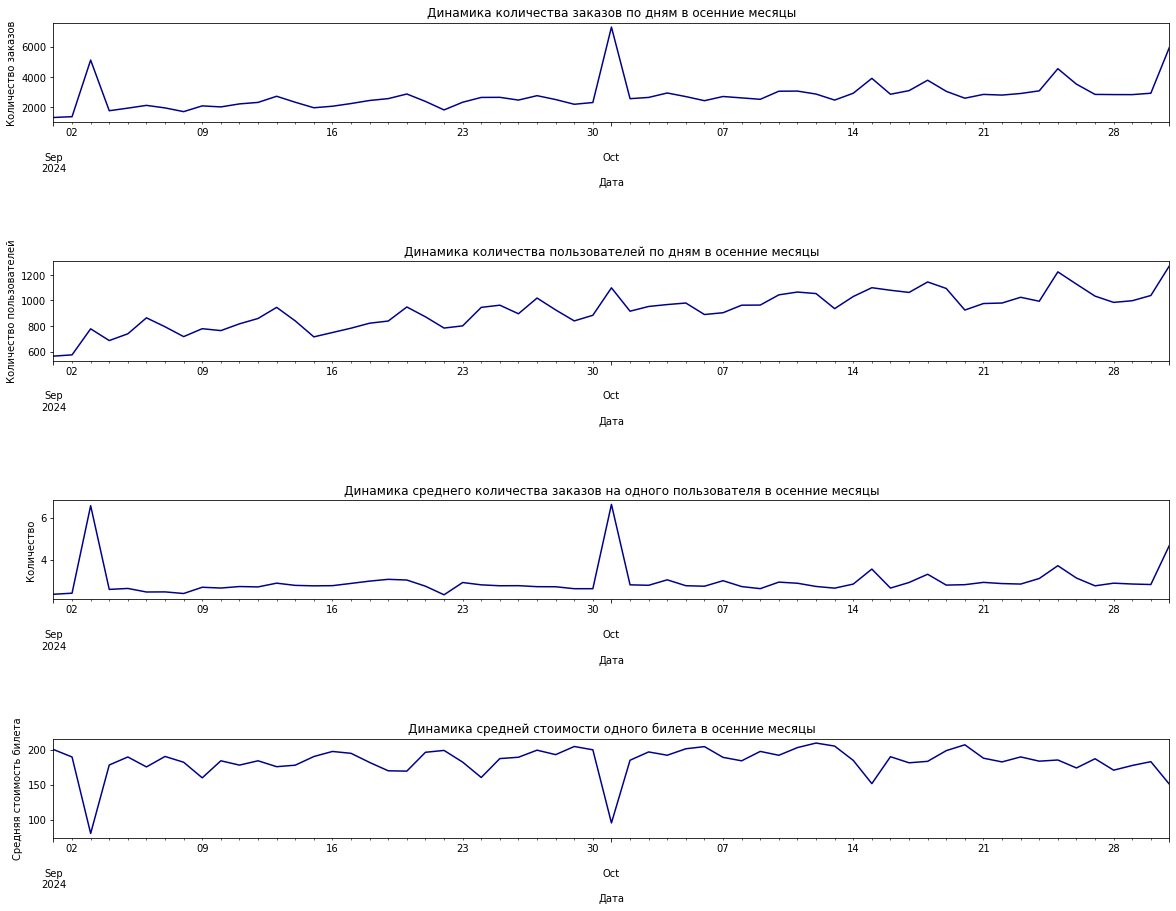

In [50]:
# Строим линейныt график: для количества заказов, пользователей, среднеим количеством заказов на одного пользователя и средней стоимостью одного билета по дням
plt.subplot(7, 1, 1)
autumn_users_activity['total_orders'].plot(
    kind='line',
    color='darkblue',
    title='Динамика количества заказов по дням в осенние месяцы',
    xlabel='Дата',
    ylabel='Количество заказов',
    figsize=(20,15)
)

plt.subplot(7, 1, 3)
autumn_users_activity['DAU'].plot(
    kind='line',
    color='darkblue',
    title='Динамика количества пользователей по дням в осенние месяцы',
    xlabel='Дата',
    ylabel='Количество пользователей',
    figsize=(20,15)
)

plt.subplot(7, 1, 5)
autumn_users_activity['orders_per_user'].plot(
    kind='line',
    color='darkblue',
    title='Динамика среднего количества заказов на одного пользователя в осенние месяцы',
    xlabel='Дата',
    ylabel='Количество',
    figsize=(20,15)
)

plt.subplot(7, 1, 7)
autumn_users_activity['avg_one_ticket_revenue'].plot(
    kind='line',
    color='darkblue',
    title='Динамика средней стоимости одного билета в осенние месяцы',
    xlabel='Дата',
    ylabel='Средняя стоимость билета',
    figsize=(20,15)
)

plt.show()

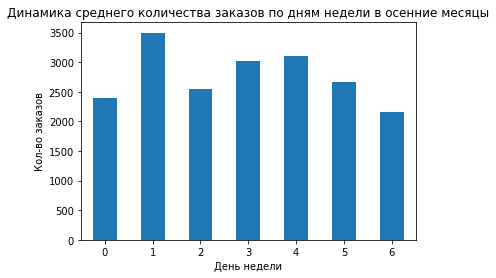

In [51]:
# Подсчитываем среднее количество заказов по дням недели
dow_groups = autumn_users_activity.groupby('day_of_week_name')['total_orders'].mean()

# Строим столбчатую диаграмму среднего количества заказов по дням недели
dow_groups.plot(
    kind='bar',
    rot=0,
    title='Динамика среднего количества заказов по дням недели в осенние месяцы',
    xlabel='День недели',
    ylabel='Кол-во заказов'
)

# Выводим график на экран
plt.show()

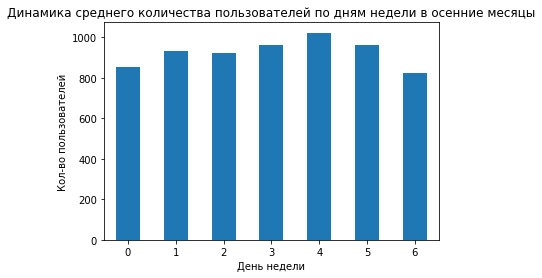

In [52]:
# Подсчитываем среднее количество пользователей по дням недели
dow_groups = autumn_users_activity.groupby('day_of_week_name')['DAU'].mean()

# Строим столбчатую диаграмму среднего количества пользователей по дням недели
dow_groups.plot(
    kind='bar',
    rot=0,
    title='Динамика среднего количества пользователей по дням недели в осенние месяцы',
    xlabel='День недели',
    ylabel='Кол-во пользователей'
)

# Выводим график на экран
plt.show()

**При анализе графиков, отображающих ключевые метрики за осенний период, можно сделать следующие аналитические выводы:**

1. Количество заказов по дням показывает выраженную недельную цикличность с ростом в пятницу. Это указывает на повышенную активность пользователей к концу рабочей недели. Кроме того, наблюдаются значительные всплески заказов в начале каждого осеннего месяца — вероятно, связано с регулярными факторами, такими как начало отчетного периода или акции.

2. Аналогичная недельная цикличность прослеживается и в динамике количества пользователей: максимумы приходится на пятницу. При этом видно общую тенденцию роста количества активных пользователей к концу октября, что может свидетельствовать о расширении аудитории или повышении вовлеченности.

3. Среднее количество заказов на одного пользователя в осенний период относительно стабильно, однако также фиксируются значительные всплески в начале каждого месяца. Это указывает, что увеличение общей активности связано не только с ростом числа пользователей, но и с увеличением заказов на единицу аудитории в эти периоды.

4. Средняя стоимость одного билета остается в целом стабильной, однако наблюдаются провалы в стоимости на начало месяца, когда одновременно увеличивается количество заказов. Вероятно, это связано с ценовыми скидками или специальными предложениями, стимулирующими рост заказов.

5. Анализ средних значений по дням недели показывает различия в пиковых значениях: максимальное количество активных пользователей приходится на пятницу, тогда как пик заказов — во вторник. Это объясняется высокой активностью в начале месяца, когда даты 3 сентября и 1 октября приходтся на вторники и создают локальные максимумы.

В целом данные свидетельствуют о выраженной недельной и месячной цикличности в поведении пользователей и заказах, с дополнительным влиянием стартовых дат месяца на ключевые метрики. Для повышения эффективности маркетинговых кампаний стоит учитывать эти циклы, фокусируясь на начале месяца и пятничных днях.

<a name="part5"></a>
#### Популярные события и партнёры

In [53]:
# Группируем данные по названию регионов и находим количество мероприятий и количество заказов в каждом
popular_reg = final_tickets_df.groupby('region_name').agg({'event_id' : 'nunique',
                                                               'order_id' : 'count'})

# Задаем названия столбцам с количеством мероприятий и количеством заказов в каждом регионе
popular_reg = popular_reg.rename(columns={'event_id': 'total_events', 'order_id': 'total_orders'})

# Находим долю мероприятий и заказов в каждом регионе по отношению к общему количеству мероприятий и заказов
popular_reg['events_share'] = popular_reg['total_events'] / popular_reg['total_events'].sum()
popular_reg['orders_share'] = popular_reg['total_orders'] / popular_reg['total_orders'].sum()

# Сортируем регионы по количеству проводимых мероприятий в порядке убывания
popular_reg.sort_values(by='total_events', ascending=False, inplace=True)

# Выводим полученный результат
display(popular_reg)

,total_events,total_orders,events_share,orders_share
region_name,,,,
Каменевский регион,5935,89662,0.265441,0.311604
Североярская область,3800,43738,0.169954,0.152004
Широковская область,1232,16169,0.055101,0.056193
Светополянский округ,1075,7501,0.048079,0.026068
Речиновская область,702,6266,0.031397,0.021776
...,...,...,...,...
Теплоозёрский округ,2,7,0.000089,0.000024
Сосноводолинская область,2,10,0.000089,0.000035
Лесноярский край,2,19,0.000089,0.000066


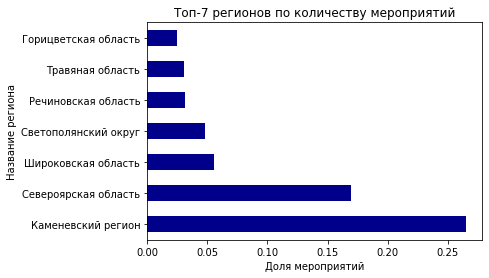

In [54]:
# Выделяем топ-7 популярных регонов по количеству проводимых мероприятий
top_7_reg = popular_reg.iloc[0:7]

# Строим диаграмму для топ-7 популярных регонов по доле проводимых мероприятий 
top_7_reg['events_share'].plot(
    kind='barh',
    rot=0,
    color='darkblue',
)

# Задаем название графика и подписи осей
plt.title('Топ-7 регионов по количеству мероприятий')
plt.xlabel('Доля мероприятий')
plt.ylabel('Название региона')

# Выводим график на экран
plt.show()

In [55]:
# Группируем данные по названию билетных операторов и находим количество мероприятий и количество заказов для каждого, а также общую выручку
popular_serv = final_tickets_df.groupby('service_name').agg({'event_id' : 'nunique',
                                                                  'order_id' : 'count',
                                                                  'revenue_rub' : 'sum'})

# Задаем названия столбцам с количеством мероприятий, количеством заказов и общей выручкой
popular_serv = popular_serv.rename(columns={'event_id': 'total_events', 'order_id': 'total_orders', 'revenue_rub': 'total_revenue'})

# Находим долю мероприятий и заказов для каждого билетного оператора по отношению к общему количеству мероприятий и заказов
popular_serv['events_share'] = popular_serv['total_events'] / popular_serv['total_events'].sum()
popular_serv['orders_share'] = popular_serv['total_orders'] / popular_serv['total_orders'].sum()

# Сортируем билетных операторов по количеству заказов в порядке убывания
popular_serv.sort_values(by='total_orders', ascending=False, inplace=True)

# Задаем формат для столбца с общей выручкой для каждого билетного оператора
popular_serv_st = popular_serv.style.format({'total_revenue': '{:.2f}'})

# Выводим полученный результат
display(popular_serv_st)

,total_events,total_orders,total_revenue,events_share,orders_share
service_name,,,,,
Билеты без проблем,4247,62856,24322065.04,0.174164,0.218445
Лови билет!,4867,40800,16673853.55,0.199590,0.141793
Билеты в руки,3530,40279,13193688.90,0.144761,0.139983
Мой билет,1300,34439,22042027.53,0.053311,0.119687
Облачко,2335,26402,18588613.84,0.095756,0.091755
Лучшие билеты,1762,17741,2724060.58,0.072258,0.061656
Весь в билетах,855,16424,16532346.51,0.035063,0.057079
Прачечная,1026,10222,4746810.51,0.042075,0.035525
Край билетов,252,6109,6405689.24,0.010334,0.021231


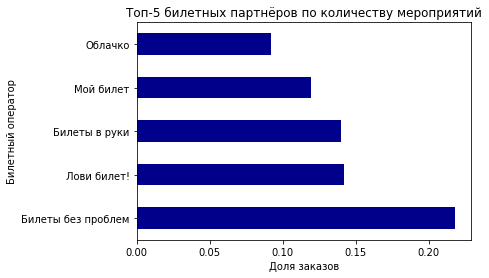

In [56]:
# Выделяем топ-5 билетных оператров по количеству заказов
top_5_serv = popular_serv.iloc[0:5]

# Строим диаграмму для топ-5 билетных оператров по количеству заказов 
top_5_serv['orders_share'].plot(
    kind='barh',
    rot=0,
    color='darkblue',
)

# Задаем название графика и подписи осей
plt.title('Топ-5 билетных партнёров по количеству мероприятий')
plt.xlabel('Доля заказов')
plt.ylabel('Билетный оператор')

# Выводим график на экран 
plt.show()

**По результатам анализа сводных таблиц можно выделить следующие ключевые выводы:**

По регионам - лидером по количеству и разнообразию проводимых мероприятий является Каменевский регион — на него приходится 25% всех мероприятий, что существенно превышает долю прочих регионов. Второе место занимает Североярская область с долей в 12%. Все остальные регионы вместе составляют менее 5% от общего количества мероприятий, что указывает на значительную концентрацию активности именно в двух упомянутых регионах.

Анализ сводной таблицы с билетными операторами показывает, что самый крупный партнер по доле заказов — оператор «Билеты без проблем», на которого приходится 22% всех заказов. Далее следуют операторы «Лови билет!», «Билеты в руки», «Мой билет» и «Облачко», каждый из которых имеет долю от 9% до 15%. Остальные операторы занимают существенно меньшие доли рынка.

Данные свидетельствуют о высокой концентрации мероприятий и заказов в нескольких ключевых регионах и у ограниченного круга билетных операторов. Для эффективного развития и расширения продаж целесообразно фокусироваться на укреплении позиций в Каменевском регионе и у ведущих операторов, а также рассматривать возможности для увеличения активности в менее охваченных регионах и у партнеров с меньшими долями.

<a name="part6"></a>
### Статистический анализ данных

Перед проведением статистического анализа необходимо выделить и проанализировать группы пользователей, использующих мобильную и десктопную версии сайта за осенние месяцы. Чтобы обеспечить точность результатов теста следует исключить пересечения между этими группами — то есть удалить пользователей, которые пользуются обеими версиями. Кроме того, требуется проверить основные статистические показатели обеих групп для дальнейшего корректного сравнения.

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b>

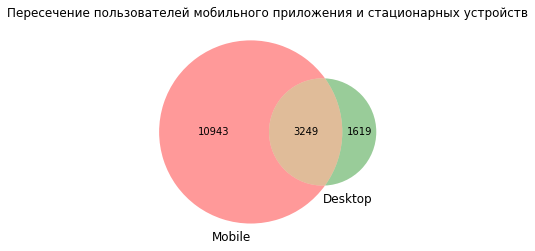

In [57]:
# Строим диаграмму Венна для визуализации наличия пересечений между двуми группами
# Преобразование датафреймов в множества для сравнения
set1 = set(autumn_orders[autumn_orders['device_type_canonical'] == 'mobile']['user_id'])
set2 = set(autumn_orders[autumn_orders['device_type_canonical'] == 'desktop']['user_id'])

# Создание диаграммы Венна
venn2([set1, set2], set_labels=('Mobile', 'Desktop'))

# Задаем наименование графика
plt.title("Пересечение пользователей мобильного приложения и стационарных устройств")

# Отображаем график
plt.show()

In [58]:
# Группируем данные по типу используемого устройства и 'user_id' и подсчитываем количество заказов для каждого пользователя
grouped_mob_and_desk = autumn_orders.groupby(['device_type_canonical','user_id'])['order_id'].count().reset_index(name='orders_cnt')
# Удаляем пользователей, встречающихся в обооих группах
grouped_mob_and_desk = grouped_mob_and_desk.drop_duplicates(subset='user_id', keep='first')
# Проверяем полученный результат
display(grouped_mob_and_desk)

,device_type_canonical,user_id,orders_cnt
0,desktop,0028d17a676f8c8,1
1,desktop,002b75ca606ba46,3
2,desktop,002ec276eee9b0b,1
3,desktop,0040e12d70fae81,1
4,desktop,005fefeabf1e678,3
...,...,...,...
19054,mobile,ffe364dd8211157,3
19055,mobile,ffe73c50cbd71fc,2
19056,mobile,ffed3ff067d4f12,3
19057,mobile,fff13b79bd47d7c,3


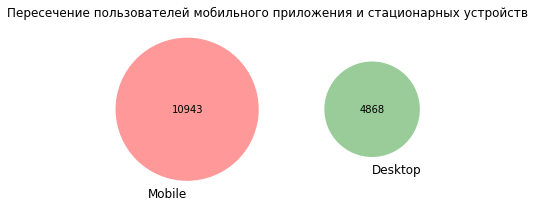

In [59]:
# Строим диаграмму Венна для визуализации наличия пересечений между двуми группами
# Преобразование датафреймов в множества для сравнения
set_1 = set(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'mobile']['user_id'])
set_2 = set(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'desktop']['user_id'])

# Создание диаграммы Венна
venn2([set_1, set_2], set_labels=('Mobile', 'Desktop'))

# Задаем наименование графика
plt.title("Пересечение пользователей мобильного приложения и стационарных устройств")

# Отображаем график
plt.show()

In [60]:
# Рассчитываем количество уникальных пользователей для каждого устройства 
groups=grouped_mob_and_desk.groupby(['device_type_canonical'])['user_id'].nunique()
a=groups['mobile']
b=groups['desktop']

In [61]:
# Рассчитываем процентную разницу в количестве пользователей мобильной и десктопной версии сайта
P = 100 * abs(a - b) / a
print(f'Количество пользоватлей мобильного приложения: {a}')
print(f'Количество пользоватлей стационарной версии сайта: {b}')
print(f'Процентная разница в количестве пользователей мобильной и десктопной версии сайта: {round(P, 2)}%')

Количество пользоватлей мобильного приложения: 10943
Количество пользоватлей стационарной версии сайта: 4868
Процентная разница в количестве пользователей мобильной и десктопной версии сайта: 55.51%


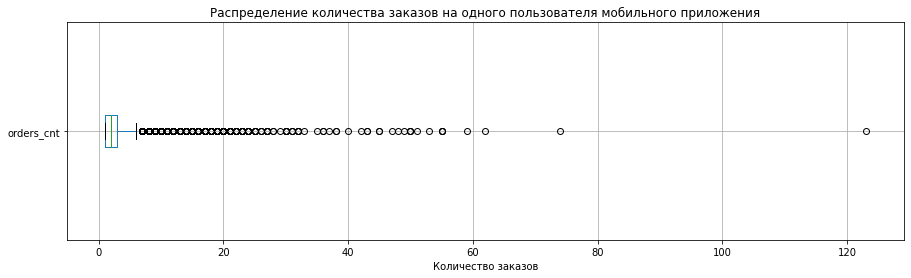

In [62]:
# Строим график boxplot для обнаружения выбрсов 
# Задаем размер графика
plt.figure(figsize=(15,4))

# Группируем данные по типу устройства "mobile"
group_mobile = grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'mobile']

# Строим график 
group_mobile.boxplot('orders_cnt', vert=False)

# Задаем название графика и подписи осей
plt.title('Распределение количества заказов на одного пользователя мобильного приложения')
plt.xlabel('Количество заказов')

# Отображаем график
plt.show()

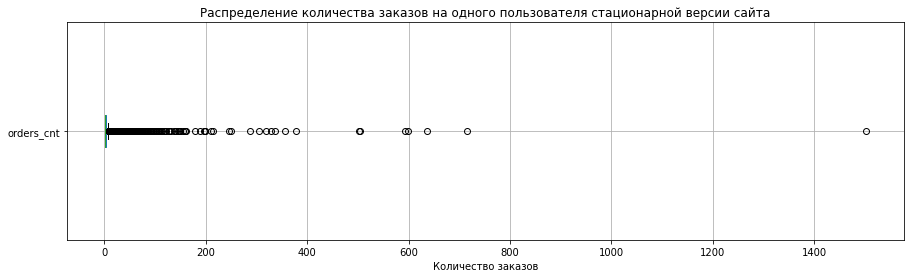

In [63]:
# Строим график boxplot для обнаружения выбрсов 
# Задаем размер графика
plt.figure(figsize=(15,4))

# Группируем данные по типу устройства "desktop"
group_desktop = grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'desktop']

# Строим график 
group_desktop.boxplot('orders_cnt', vert=False)

# Задаем название графика и подписи осей
plt.title('Распределение количества заказов на одного пользователя стационарной версии сайта')
plt.xlabel('Количество заказов')

# Отображаем график
plt.show()

In [64]:
mobile_mean = round(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'mobile']['orders_cnt'].mean(), 2)
desktop_mean = round(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'desktop']['orders_cnt'].mean(), 2)
print(f'Среднее количество заказов на одного пользователя мобильного приложения: {mobile_mean}')
print(f'Среднее количевтво заказов на одного пользователя десктопной версии сайта: {desktop_mean}')

Среднее количество заказов на одного пользователя мобильного приложения: 2.86
Среднее количевтво заказов на одного пользователя десктопной версии сайта: 7.05


In [65]:
mobile_median = round(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'mobile']['orders_cnt'].median(), 2)
desktop_median = round(grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'desktop']['orders_cnt'].median(), 2)
print(f'Медиана количества заказов на одного пользователя мобильного приложения: {mobile_median}')
print(f'Медиана количевтва заказов на одного пользователя десктопной версии сайта: {desktop_median}')

Медиана количества заказов на одного пользователя мобильного приложения: 2.0
Медиана количевтва заказов на одного пользователя десктопной версии сайта: 2.0


При первичном анализе данных о заказах пользователей было выявлено, что группы пользователей, разделённые по типу используемого устройства, не являются равномерными. Процентная разница в количестве пользователей мобильной и десктопной версий сайта составляет 55,51%, что указывает на значительное преобладание одной группы над другой.

Среднее количество заказов между двумя группами также демонстрирует существенные различия. Однако эти данные могут быть искажены наличием значительных выбросов в количестве заказов среди пользователей десктопной версии сайта. Это означает, что среднее значение может не полностью отражать реальное распределение заказов в каждой группе.

С другой стороны, медианные значения количества заказов на одного пользователя в обеих группах не различаются. Это может свидетельствовать о том, что, несмотря на различия в средних значениях, основные тенденции в количестве заказов на пользователя в обеих группах схожи.

Для подтверждения или опровержения этого заключения необходимо провести статистический тест Уэлча. Этот метод выбран из-за его устойчивости к неравенству дисперсий и разным размерам выборок, что особенно важно при значительной разнице в численности групп. Тест Уэлча позволит определить, существуют ли статистически значимые различия между двумя группами по количеству заказов на одного пользователя, учитывая возможные различия в дисперсиях и размерах выборок.

**Нулевая гипотеза H₀:** Среднее количество заказов на одного пользователя мобильного приложения равно среднему количесвтву заказов на одного пользователя стационарного устройства.

**Альтернативная односторонняя гипотеза H₁:** Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [66]:
group_mobile = grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'mobile']['orders_cnt']
group_desktop = grouped_mob_and_desk[grouped_mob_and_desk['device_type_canonical'] == 'desktop']['orders_cnt']

alpha = 0.05

t_stat, p_value = ttest_ind(group_mobile, group_desktop, alternative='greater', equal_var=False)

if p_value > alpha:
    print(f'p_value = {p_value}. Нулевая гипотеза находит подтверждение.')
    print('Среднее количество заказов на одного пользователя среди двух групп (ипользующих мобильную и десктопную версии) не различается.')
else:
    print(f'p_value = {p_value}. Нулевая гипотеза не находит подтверждение.')
    print('Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо.')

p_value = 0.9999999999999997. Нулевая гипотеза находит подтверждение.
Среднее количество заказов на одного пользователя среди двух групп (ипользующих мобильную и десктопную версии) не различается.


В результате проведённого статистического теста Уэлча была подтверждена гипотеза об отсутствии значимых различий в количестве заказов на одного пользователя между группами пользователей мобильного приложения и стационарной версии сайта. 

In [67]:
# Отбираем данные с указанием количества дней с предыдущего заказа
df_days_sinse_prev = autumn_orders.dropna(subset=['days_since_prev'])
# Группируем данные по типу используемого устройства и 'user_id' и подсчитываем среднее количесвто дней с предыдущего заказа
mob_and_desk_days_sinse_prev = df_days_sinse_prev.groupby(['device_type_canonical','user_id'])['days_since_prev'].mean().reset_index(name='avg_days_since_prev')
# Удаляем пользователей, встречающихся в обооих группах
mob_and_desk_days_sinse_prev = mob_and_desk_days_sinse_prev.drop_duplicates(subset='user_id', keep='first')
# Проверяем полученный результат
display(mob_and_desk_days_sinse_prev)

,device_type_canonical,user_id,avg_days_since_prev
0,desktop,002b75ca606ba46,4.666667
1,desktop,002ec276eee9b0b,10.000000
2,desktop,0040e12d70fae81,39.000000
3,desktop,005fefeabf1e678,0.000000
4,desktop,006d1660d830822,12.428571
...,...,...,...
14223,mobile,ffdfac9273f943b,1.000000
14224,mobile,ffe364dd8211157,41.333333
14225,mobile,ffe73c50cbd71fc,0.000000
14226,mobile,ffed3ff067d4f12,26.000000


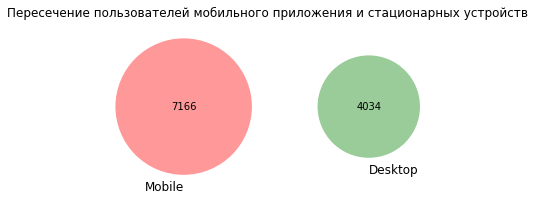

In [68]:
# Строим диаграмму Венна для визуализации наличия пересечений между двуми группами
# Преобразование датафреймов в множества для сравнения
set1 = set(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'mobile']['user_id'])
set2 = set(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'desktop']['user_id'])

# Создание диаграммы Венна
venn2([set1, set2], set_labels=('Mobile', 'Desktop'))

# Задаем наименование графика
plt.title("Пересечение пользователей мобильного приложения и стационарных устройств")

# Отображаем график
plt.show()

In [69]:
# Рассчитываем количество уникальных пользователей для каждого устройства 
groups=mob_and_desk_days_sinse_prev.groupby(['device_type_canonical'])['user_id'].nunique()
a=groups['mobile']
b=groups['desktop']

In [70]:
# Рассчитываем процентную разницу в количестве пользователей мобильной и десктопной версии сайта
P = 100 * abs(a - b) / a
print(f'Количество пользоватлей мобильного приложения: {a}')
print(f'Количество пользоватлей стационарной версии сайта: {b}')
print(f'Процентная разница в количестве пользователей мобильной и десктопной версии сайта: {round(P, 2)}%')

Количество пользоватлей мобильного приложения: 7166
Количество пользоватлей стационарной версии сайта: 4034
Процентная разница в количестве пользователей мобильной и десктопной версии сайта: 43.71%


In [71]:
mobile_mean = round(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'mobile']['avg_days_since_prev'].mean(), 2)
desktop_mean = round(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'desktop']['avg_days_since_prev'].mean(), 2)
print(f'Среднее время между заказами пользователей мобильного приложения: {mobile_mean}')
print(f'Среднее время между заказами пользователей десктопной версии сайта: {desktop_mean}')

Среднее время между заказами пользователей мобильного приложения: 25.07
Среднее время между заказами пользователей десктопной версии сайта: 14.86


In [72]:
mobile_median = round(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'mobile']['avg_days_since_prev'].median(), 2)
desktop_median = round(mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'desktop']['avg_days_since_prev'].median(), 2)
print(f'Медиана времени между заказами пользователей мобильного приложения: {mobile_median}')
print(f'Медиана времени между заказами пользователей десктопной версии сайта: {desktop_median}')

Медиана времени между заказами пользователей мобильного приложения: 14.0
Медиана времени между заказами пользователей десктопной версии сайта: 4.5


В ходе предварительного анализа данных было обнаружено, что группы пользователей, использующие разные устройства, имеют различный размер. Процентная разница в количестве пользователей мобильной и десктопной версий сайта составляет 43,71%.

Средние и медианные значения времени между заказами для пользователей мобильного приложения и стационарной версии сайта демонстрируют существенные различия. Среднее время между заказами для пользователей мобильного приложения значительно больше, чем для пользователей десктопной версии сайта. Это может свидетельствовать о различных поведенческих тенденциях между двумя группами пользователей.

Для подтверждения или опровержения этих наблюдений предлагается также провести статистический тест Уэлча. Этот метод выбран из-за его устойчивости к неравенству дисперсий и разным размерам выборок, что особенно важно при значительной разнице в численности групп. Тест Уэлча позволит определить, существуют ли статистически значимые различия между двумя группами по времени между заказами, учитывая возможные различия в дисперсиях и размерах выборок.

**Нулевая гипотеза H₀:** Среднее время между заказами пользователей мобильного приложения равно время между заказами пользователей стационарного устройства.

**Альтернативная односторонняя гипотеза H₁:** Среднее время между заказами пользователей мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [73]:
group_mobile = mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'mobile']['avg_days_since_prev']
group_desktop = mob_and_desk_days_sinse_prev[mob_and_desk_days_sinse_prev['device_type_canonical'] == 'desktop']['avg_days_since_prev']

alpha = 0.05

t_stat, p_value = ttest_ind(group_mobile, group_desktop, alternative='greater', equal_var=False)

if p_value > alpha:
    print(f'p_value = {p_value}. Нулевая гипотеза находит подтверждение.')
    print('Среднее время между заказами пользователей среди двух групп (ипользующих мобильную и десктопную версии) не различается.')
else:
    print(f'p_value = {p_value}. Нулевая гипотеза не находит подтверждение.')
    print('Среднее время между заказами пользователей мобильного приложения выше по сравнению с пользователями стационарных устройств,  и данное различие статистически значимо.')

p_value = 2.9766392104196743e-84. Нулевая гипотеза не находит подтверждение.
Среднее время между заказами пользователей мобильного приложения выше по сравнению с пользователями стационарных устройств,  и данное различие статистически значимо.


В результате проведённого теста Уэлча было подтверждено, что среднее время между заказами пользователей мобильного приложения действительно выше, чем у пользователей стационарной версии сайта. Этот вывод имеет важное значение для понимания различий в поведении пользователей и их взаимодействии с платформой.

Полученные результаты могут указывать на то, что пользователи мобильного приложения совершают заказы реже по сравнению с пользователями стационарной версии. Это может быть обусловлено различными факторами, такими как удобство использования приложения, доступность функций, особенности интерфейса или даже различия в целевой аудитории.

<a name="part7"></a>
### Общий вывод и рекомендации


**В ходе данного проекта были проведена обработка следующих данных:**

- датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных, 
- датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия 
- датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год для обработки заказов оплаченных в казахстанских тенге.


В результате предварительной обработки были удалены строки, дублирующиеся по основным столбцам, описывающим информацию о заказах. Также были исключены выбросы по значению выручки, которые превышали 99-й перцентиль. Процент удаленных данных составляет 0,99%. Преобразованы типпы данных: данные содержащие дату и время приведены к формату datetime, а для численных данных была снижена размерность. Созданы новые столбцы для дальнейшего анализа данных:
`revenue_rub`, `one_ticket_revenue_rub`, `month`, `season`.


**Основные результаты анализа:**

Осень сопровождается значительным ростом активности покупателей, особенно в сегментах спортивных и театральных событий, а также новогодних ёлок, что отражает сезонные традиции и запуск соответствующих программ. Увеличивается доля детских и семейных мероприятий (0+ и 12+), а выручка с билетов на выставки и стендап в этот период выше. 

Пользовательская активность демонстрирует выраженную недельную цикличность с пиками в пятницу и всплесками заказов в начале каждого осеннего месяца, связанными с внешними факторами (отчёты, акции). Прирост активности обусловлен как увеличением числа пользователей, так и ростом заказов на одного пользователя в пиковые периоды. 

Региональная активность концентрируется преимущественно в Каменевском (25%) и Североярском (12%) регионах, остальные крайне малочисленны. Среди билетных операторов лидирует «Билеты без проблем» (22% заказов).

Тест Уэлча показывает отсутствие значимых различий в числе заказов на пользователя между мобильной и веб-версией, однако мобильные пользователи делают заказы реже. Это указывает на устойчивый выбор устройств, при этом различия в частоте взаимодействия с платформой требуют внимания при оптимизации сервисов.

**Рекомендации:**

1. Усилить маркетинг и коммуникации осенью. Следует планировать специальные акции и промо-кампании в осенние месяцы, особенно на спортивные, театральные мероприятия и новогодние ёлки. А также учитывать рост интереса к детским и семейным событиям, предлагая соответствующий контент и скидки.

2. Оптимизировать расписание и предложения к началу месяца и пятнице. Пиковая активность в начале месяца и в пятницу требует подготовки особых предложений и увеличения ресурсной поддержки сервисов в эти периоды.

3. Фокус на Каменевском и Североярском регионах. стоит инвестировать в развитие и маркетинг именно в этих регионах, где сосредоточена основная часть мероприятий.

4. Развивать сотрудничество с лидирующими билетными операторами. «Билеты без проблем» и другие крупные партнеры обеспечивают большую долю заказов.

5. Уделить внимание пользователям мобильного приложения. Поскольку мобильные пользователи дольше делают паузы между заказами, стоит улучшать мобильный пользовательский опыт, стимулировать частоту заказов через push-уведомления, персональные рекомендации и удобные механизмы повторных покупок.